In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, MeanShift, estimate_bandwidth
from scipy.cluster.hierarchy import linkage, dendrogram

from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

### Load & Explore
- Load CSV, check types/duplicates/missing, summary stats, histograms, correlation heatmap.

In [2]:
df = pd.read_csv("Wholesale customers data.csv")

In [3]:
print("Shape:", df.shape)


Shape: (440, 8)


In [4]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB


In [5]:
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [6]:
print("Duplicates:", df.duplicated().sum())


Duplicates: 0


In [7]:
print("Missing:\n", df.isna().sum())


Missing:
 Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64


In [8]:
df.describe()


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


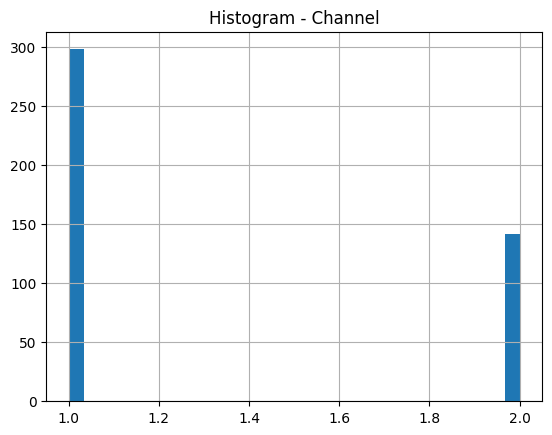

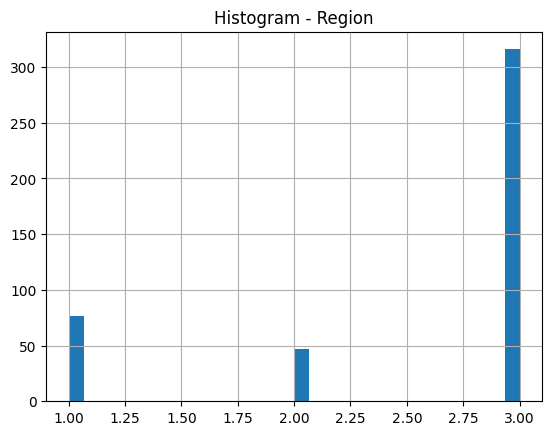

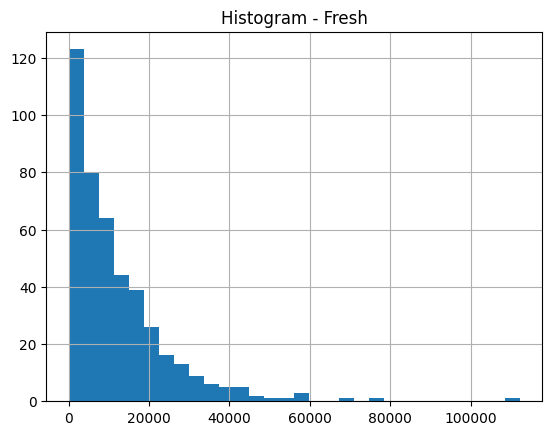

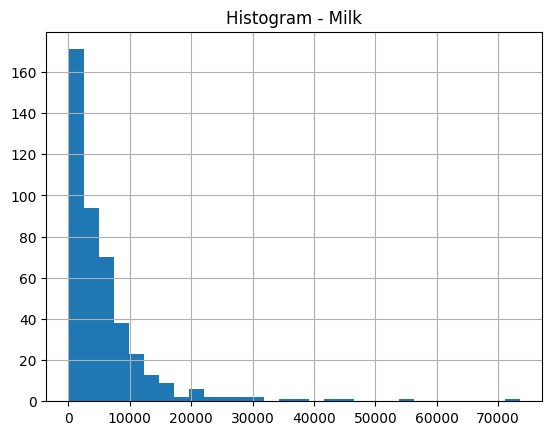

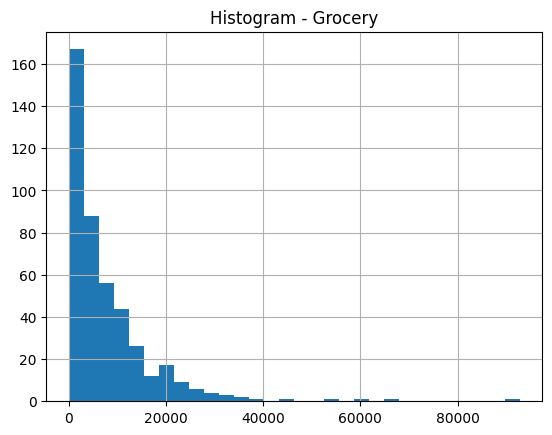

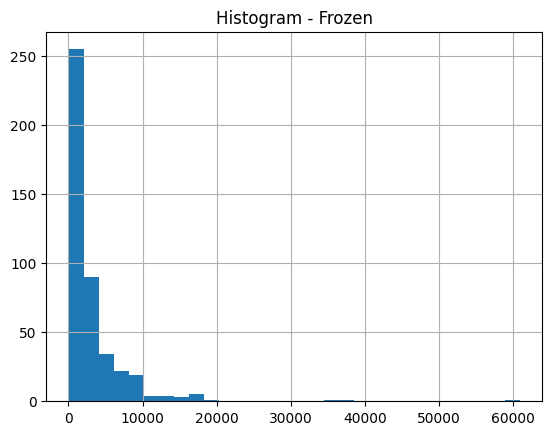

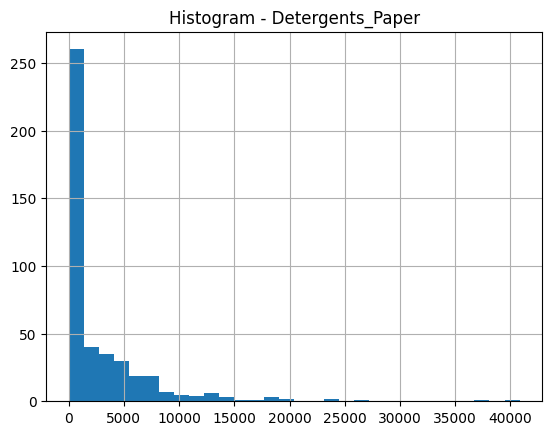

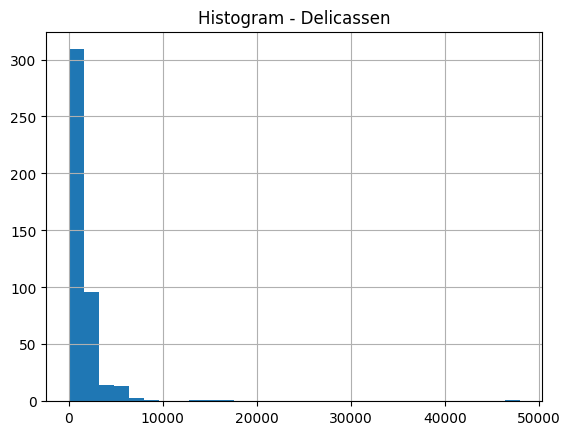

In [9]:
for col in df.select_dtypes(include='number').columns:
    plt.figure()
    df[col].hist(bins=30)
    plt.title(f"Histogram - {col}")
    plt.show()

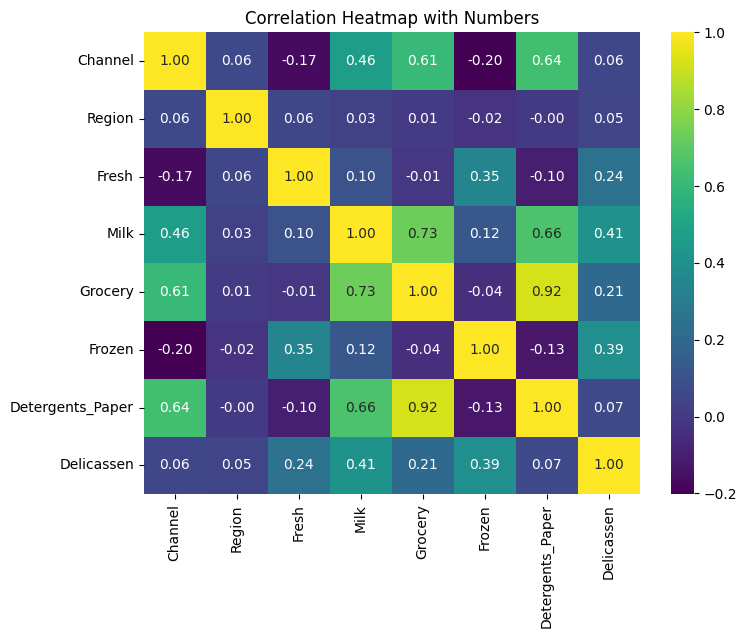

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = df.corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="viridis", cbar=True)
plt.title("Correlation Heatmap with Numbers")
plt.show()


### Preprocessing
- `log1p` to reduce skew → `StandardScaler` to standardize.

In [11]:
features = df.drop(columns=["Channel", "Region"])


In [12]:
features_log = np.log1p(features)

In [13]:
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_log)
print("✅ Preprocessing Done:")
print("Shape:", features_scaled.shape)

✅ Preprocessing Done:
Shape: (440, 6)


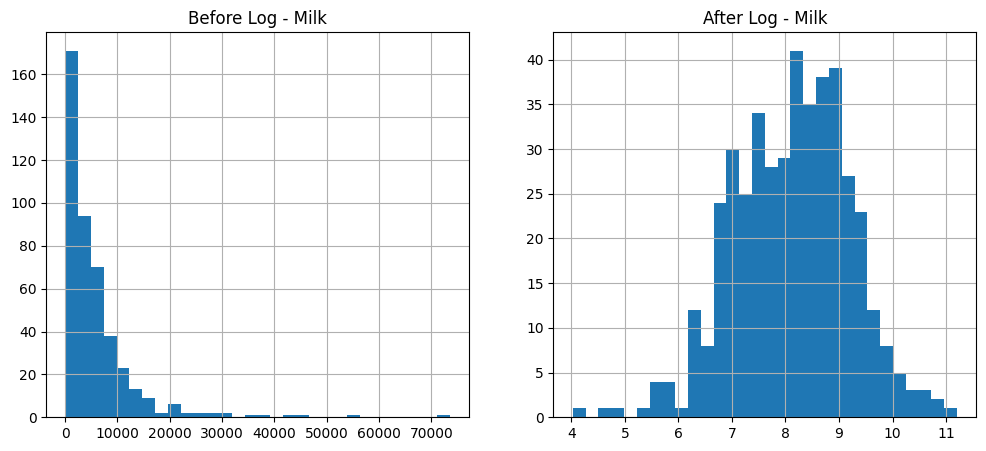

In [14]:
col = "Milk"

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
features[col].hist(bins=30)
plt.title(f"Before Log - {col}")

plt.subplot(1,2,2)
features_log[col].hist(bins=30)
plt.title(f"After Log - {col}")

plt.show()

### Clustering
-`K-Means` (Elbow/Silhouette), `Hierarchical` (dendrogram + linkages), `DBSCAN` (tune eps/min_samples), `MeanShift` (auto bandwidth).

#### k-means

In [32]:
X = features_scaled  

inertia = []
silhouette = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)   
    silhouette.append(silhouette_score(X, kmeans.labels_))

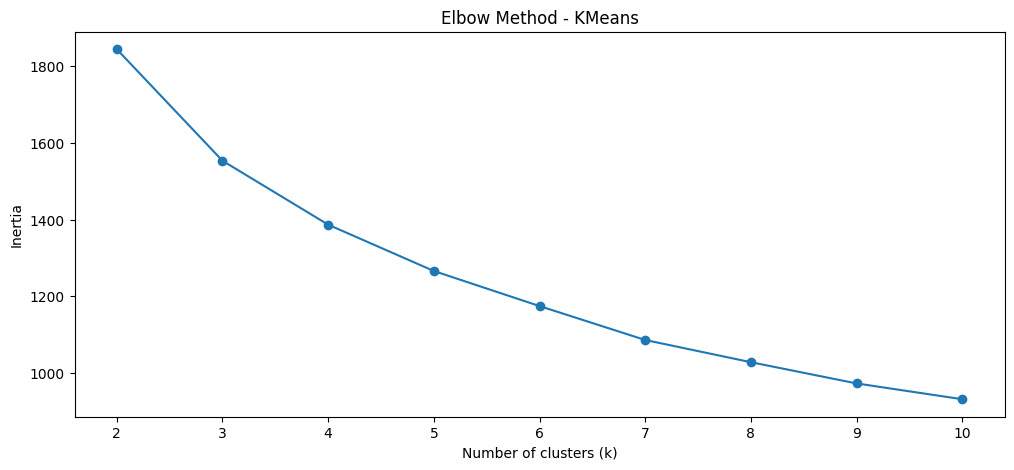

In [33]:
plt.figure(figsize=(12,5))
plt.plot(K_range, inertia, marker='o')
plt.title("Elbow Method - KMeans")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.show()

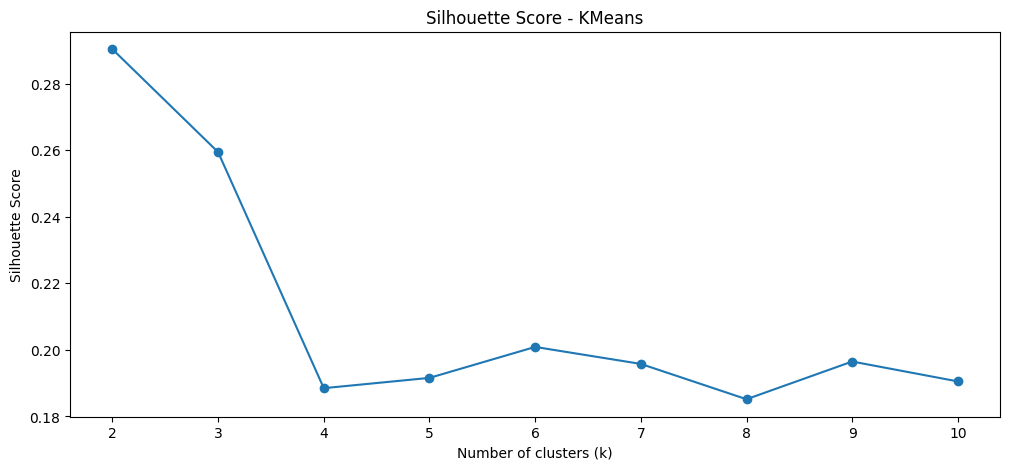

In [34]:
plt.figure(figsize=(12,5))
plt.plot(K_range, silhouette, marker='o')
plt.title("Silhouette Score - KMeans")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.show()


In [35]:
best_k = 3  
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
labels = kmeans.fit_predict(X)

In [36]:
print("✅ KMeans Done with k =", best_k)
print("Silhouette Score:", silhouette_score(X, labels))

✅ KMeans Done with k = 3
Silhouette Score: 0.25941565559741453


### Hierarchical


In [37]:
X = features_scaled  
np.random.seed(42)
idx = np.random.choice(X.shape[0], size=min(100, X.shape[0]), replace=False)
Z = linkage(X[idx], method="ward")  

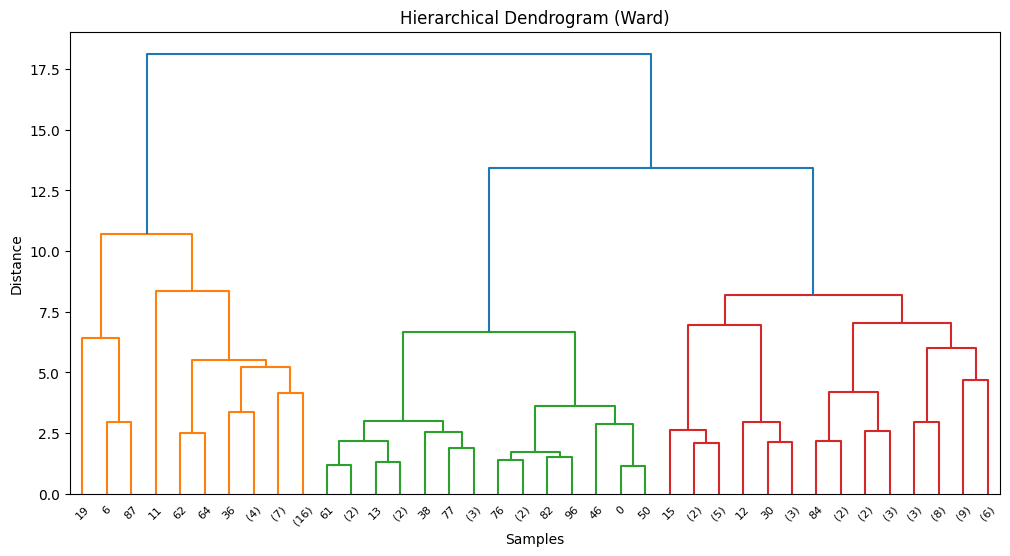

In [38]:
plt.figure(figsize=(12, 6))
dendrogram(Z, truncate_mode="level", p=5)  # إظهار المستويات العليا فقط
plt.title("Hierarchical Dendrogram (Ward)")
plt.xlabel("Samples")
plt.ylabel("Distance")
plt.show()

In [39]:
linkages = ["ward", "average", "complete"]
k_range = range(2, 11)
results = []

In [40]:
for link in linkages:
    best_k, best_sil = None, -1
    for k in k_range:
        model = AgglomerativeClustering(n_clusters=k, linkage=link)  # metric=euclidean افتراضي
        labels = model.fit_predict(X)
        sil = silhouette_score(X, labels)
        results.append((link, k, sil))
        if sil > best_sil:
            best_k, best_sil = k, sil
    print(f"Best for {link}: k={best_k}, silhouette={best_sil:.3f}")

Best for ward: k=2, silhouette=0.258
Best for average: k=2, silhouette=0.569
Best for complete: k=2, silhouette=0.322


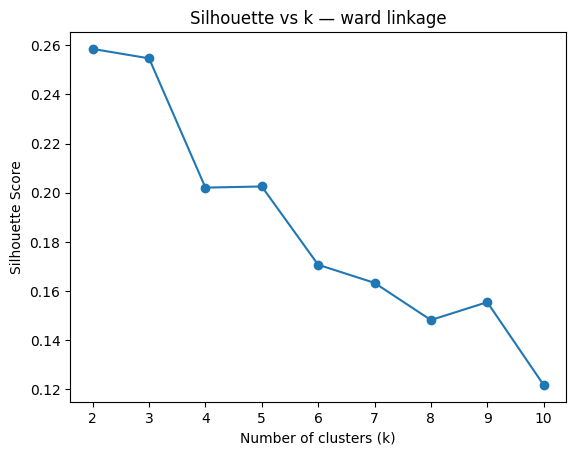

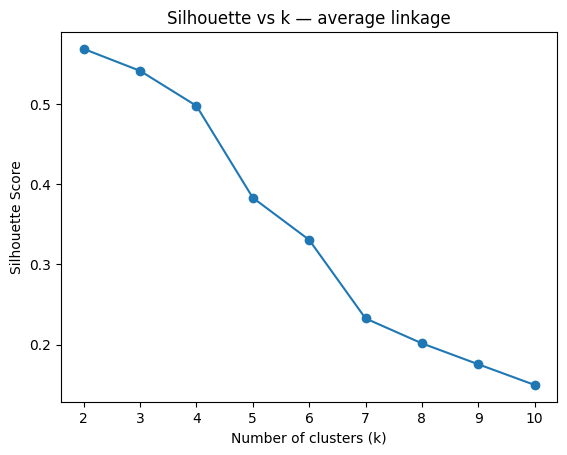

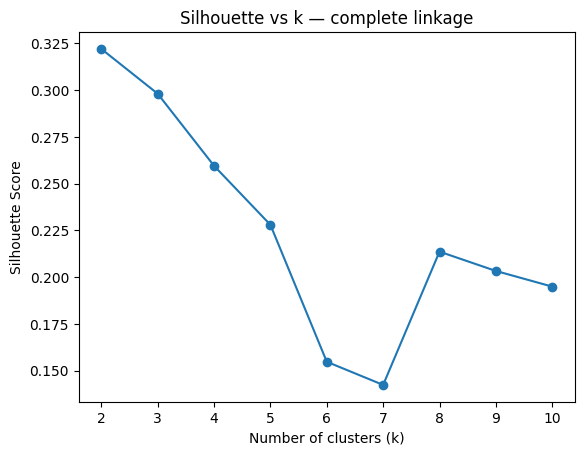

In [41]:
for link in linkages:
    ks   = [k for l, k, s in results if l == link]
    sils = [s for l, k, s in results if l == link]
    plt.figure()
    plt.plot(ks, sils, marker="o")
    plt.title(f"Silhouette vs k — {link} linkage")
    plt.xlabel("Number of clusters (k)")
    plt.ylabel("Silhouette Score")
    plt.show()

In [42]:
best_overall = max(results, key=lambda t: t[2])
best_link, best_k, best_sil = best_overall
final_model = AgglomerativeClustering(n_clusters=best_k, linkage=best_link)
final_labels = final_model.fit_predict(X)
print(f"✅ Final Agglomerative → linkage={best_link}, k={best_k}, silhouette={best_sil:.3f}")


✅ Final Agglomerative → linkage=average, k=2, silhouette=0.569


### DBSCAN

In [43]:
X = features_scaled  

eps_values = [0.5, 1, 1.5, 2, 3]
min_samples_values = [3, 5, 10]
results = []

for eps in eps_values:
    for ms in min_samples_values:
        db = DBSCAN(eps=eps, min_samples=ms)
        labels = db.fit_predict(X)
        if len(set(labels)) > 1 and len(set(labels)) != 1 + (-1 in labels):
            sil = silhouette_score(X, labels)
            results.append((eps, ms, sil, len(set(labels))))
            print(f"eps={eps}, min_samples={ms} → clusters={len(set(labels))}, silhouette={sil:.3f}")
        else:
            print(f"eps={eps}, min_samples={ms} → failed (all noise or single cluster)")



eps=0.5, min_samples=3 → clusters=9, silhouette=-0.399
eps=0.5, min_samples=5 → failed (all noise or single cluster)
eps=0.5, min_samples=10 → failed (all noise or single cluster)
eps=1, min_samples=3 → clusters=7, silhouette=-0.162
eps=1, min_samples=5 → failed (all noise or single cluster)
eps=1, min_samples=10 → failed (all noise or single cluster)
eps=1.5, min_samples=3 → clusters=3, silhouette=0.299
eps=1.5, min_samples=5 → failed (all noise or single cluster)
eps=1.5, min_samples=10 → failed (all noise or single cluster)
eps=2, min_samples=3 → failed (all noise or single cluster)
eps=2, min_samples=5 → failed (all noise or single cluster)
eps=2, min_samples=10 → failed (all noise or single cluster)
eps=3, min_samples=3 → failed (all noise or single cluster)
eps=3, min_samples=5 → failed (all noise or single cluster)
eps=3, min_samples=10 → failed (all noise or single cluster)


In [44]:
if results:
    best = max(results, key=lambda t: t[2])
    print(f"\nBest DBSCAN: eps={best[0]}, min_samples={best[1]}, clusters={best[3]}, silhouette={best[2]:.3f}")
    db_final = DBSCAN(eps=best[0], min_samples=best[1])
    labels_db = db_final.fit_predict(X)
else:
    print("No valid DBSCAN configuration found.")



Best DBSCAN: eps=1.5, min_samples=3, clusters=3, silhouette=0.299


### MeanShift Clustering

In [45]:


X = features_scaled   

bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=200)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
labels_ms = ms.fit_predict(X)

n_clusters = len(np.unique(labels_ms))
print("Number of clusters:", n_clusters)

if n_clusters > 1:
    sil = silhouette_score(X, labels_ms)
    print("Silhouette Score:", sil)
else:
    print("All data points ended up in one cluster → Silhouette cannot be calculated")


Number of clusters: 9
Silhouette Score: 0.21824996496171448


### Evaluation
- Metrics: Silhouette ↑, Davies–Bouldin ↓, Calinski–Harabasz ↑.

In [ ]:
evaluation_results = []

def evaluate_model(name, X, labels):
    if len(set(labels)) < 2:
        return (name, len(set(labels)), None, None, None)
    sil = silhouette_score(X, labels)
    dbi = davies_bouldin_score(X, labels)
    chi = calinski_harabasz_score(X, labels)
    return (name, len(set(labels)), sil, dbi, chi)

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
labels_km = kmeans.fit_predict(X)
evaluation_results.append(evaluate_model("KMeans", X, labels_km))

from sklearn.cluster import AgglomerativeClustering
hier = AgglomerativeClustering(n_clusters=2, linkage="ward")
labels_hc = hier.fit_predict(X)
evaluation_results.append(evaluate_model("Hierarchical", X, labels_hc))

from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=1.5, min_samples=5)  # replace with your best eps, min_samples
labels_db = dbscan.fit_predict(X)
evaluation_results.append(evaluate_model("DBSCAN", X, labels_db))

from sklearn.cluster import MeanShift, estimate_bandwidth
bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=200)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
labels_ms = ms.fit_predict(X)
evaluation_results.append(evaluate_model("MeanShift", X, labels_ms))

eval_df = pd.DataFrame(evaluation_results, columns=["Method", "Clusters", "Silhouette", "Davies-Bouldin", "Calinski-Harabasz"])
print(eval_df)


         Method  Clusters  Silhouette  Davies-Bouldin  Calinski-Harabasz
0        KMeans         2    0.290328        1.351502         189.049797
1  Hierarchical         2    0.258495        1.600363         134.624461
2        DBSCAN         2    0.348377        3.700702          16.900172
3     MeanShift         9    0.218250        1.117524          17.230559


### Visualization
- `PCA` and `t‑SNE` 2D scatter plots by cluster labels.

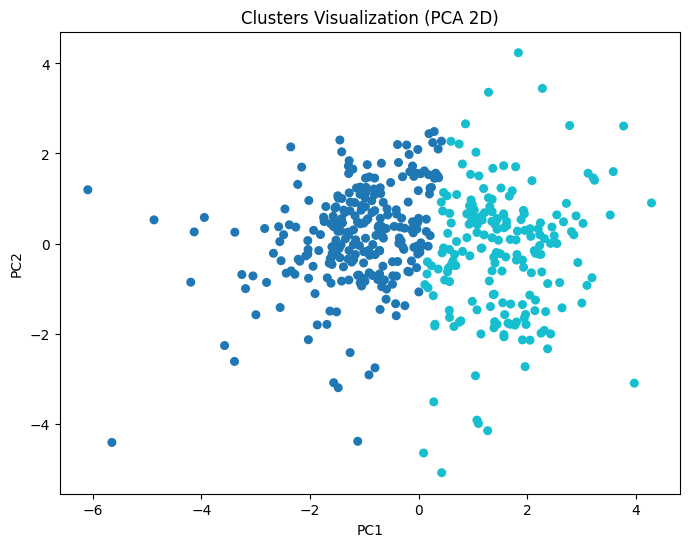

c:\Users\pc\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


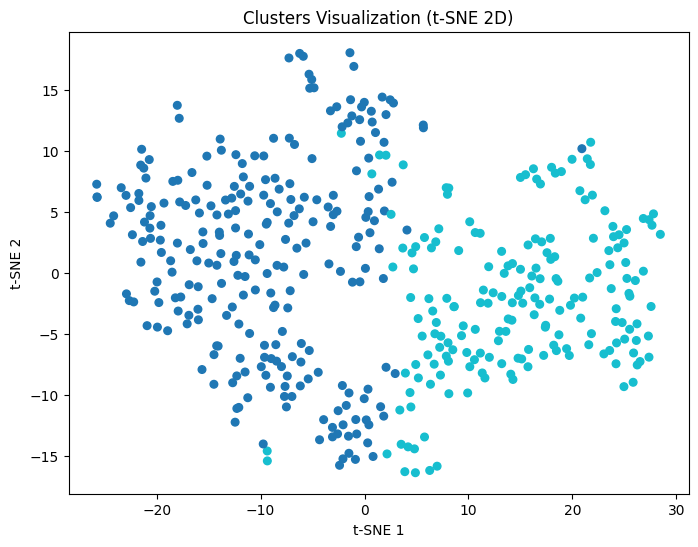

In [ ]:
labels = labels_km

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels, cmap="tab10", s=30)
plt.title("Clusters Visualization (PCA 2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(X)

plt.figure(figsize=(8,6))
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=labels, cmap="tab10", s=30)
plt.title("Clusters Visualization (t-SNE 2D)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.show()


# Cluster Profiles Interpretation

## Cluster 0 (Blue)
- High in **Fresh** and **Frozen**.
- Low in **Milk**, **Grocery**, **Detergents_Paper**.
- **Interpretation**: Likely represents **Restaurants / Hotels**, 
  where demand is high for fresh and frozen products.

## Cluster 1 (Orange)
- High in **Milk**, **Grocery**, **Detergents_Paper**.
- Lower in **Fresh** and **Frozen**.
- **Interpretation**: Likely represents **Retailers / Supermarkets**, 
  focused on consumer packaged goods.


Average spending per feature by cluster:
          Channel    Region         Fresh          Milk       Grocery  \
Cluster                                                                 
0        1.031746  2.507937  13973.126984   2401.750000   2918.706349   
1        1.712766  2.590426   9355.867021  10346.361702  14697.063830   

              Frozen  Detergents_Paper   Delicassen  
Cluster                                              
0        3705.670635        491.944444  1038.043651  
1        2222.452128       6084.505319  2177.425532  


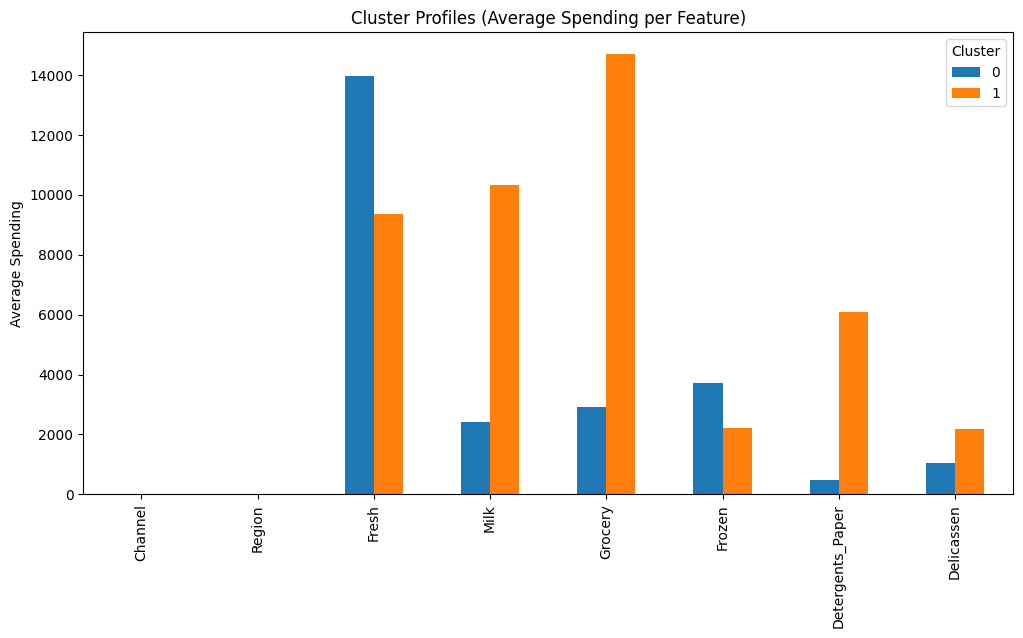

In [31]:

df_clusters = df.copy()
df_clusters["Cluster"] = labels_km   


cluster_means = df_clusters.groupby("Cluster").mean()

print("Average spending per feature by cluster:")
print(cluster_means)

import matplotlib.pyplot as plt
cluster_means.T.plot(kind="bar", figsize=(12,6))
plt.title("Cluster Profiles (Average Spending per Feature)")
plt.ylabel("Average Spending")
plt.show()
